In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels

https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html

ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range.

In [2]:
# Minst Image file to Tensors
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root = 'data',
                            train = True,
                            download = True,
                            transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
test_data = datasets.MNIST(root = 'data',
                           train = False,
                           download = True,
                           transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
type(train_data[0])

tuple

In [8]:
image, label = train_data[0]

In [9]:
image.shape

torch.Size([1, 28, 28])

In [10]:
label

5

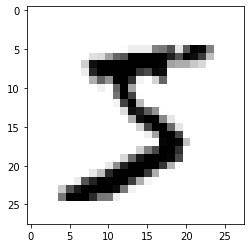

In [11]:
plt.imshow(image.reshape(28,28),cmap = 'gist_yarg')

In [12]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_data, batch_size= 500, shuffle= False)

In [13]:
from torchvision.utils import make_grid

In [14]:
# Grabbing the first batch
for images, labels in train_loader:
    break

In [15]:
labels.shape

torch.Size([100])

Labels:  [7 2 3 5 8 5 3 6 9 9 1 3]


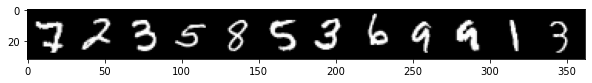

In [16]:
# make_grid(): Makes a grid of images

#print the labels
print('Labels: ', labels[:12].numpy())

im = make_grid(images[:12],nrow = 12)
plt.figure(figsize = (10, 4))

# change from color channel, width, height to width, height, color channel
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

In [17]:
# creating a multi layer perceptron

class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_sz = 784, out_sz = 10, layers = [120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
        
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim = 1) # Multi Class classification

In [18]:
torch.manual_seed(101)

model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)

# torch.optim is a package implementing various optimization algorithms.

In [21]:
import time
start_time = time.time()

# Training
epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        b +=1
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr
        
        optimizer.zero_grad() 
# zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_correct.item()/b
            print(f"Epoch {i}, Batch {b}, loss: {loss.item()}, accuracy: {acc}")
                  
    train_losses.append(loss.item())
    train_correct.append(trn_correct.item())
                  
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
                  y_val = model(X_test.view(500,-1)) #use view to flatten out the image
                  predicted = torch.max(y_val.data,1)[1]
                  tst_correct += (predicted == y_test).sum()
                  
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_correct.item())

total_time = time.time()- start_time
print(f"Duration {total_time/60} mins")

Epoch 0, Batch 200, loss: 0.23547586798667908, accuracy: 83.25
Epoch 0, Batch 400, loss: 0.35573771595954895, accuracy: 87.5225
Epoch 0, Batch 600, loss: 0.13726472854614258, accuracy: 89.56666666666666
Epoch 1, Batch 200, loss: 0.24964779615402222, accuracy: 94.91
Epoch 1, Batch 400, loss: 0.1480870395898819, accuracy: 95.12
Epoch 1, Batch 600, loss: 0.07658690214157104, accuracy: 95.38833333333334
Epoch 2, Batch 200, loss: 0.08824576437473297, accuracy: 96.55
Epoch 2, Batch 400, loss: 0.06343883275985718, accuracy: 96.6575
Epoch 2, Batch 600, loss: 0.06304910033941269, accuracy: 96.71833333333333
Epoch 3, Batch 200, loss: 0.11255666613578796, accuracy: 97.61
Epoch 3, Batch 400, loss: 0.05446586757898331, accuracy: 97.4675
Epoch 3, Batch 600, loss: 0.03222748264670372, accuracy: 97.49
Epoch 4, Batch 200, loss: 0.11783725023269653, accuracy: 98.125
Epoch 4, Batch 400, loss: 0.0467134527862072, accuracy: 97.9875
Epoch 4, Batch 600, loss: 0.05397912859916687, accuracy: 97.98833333333333


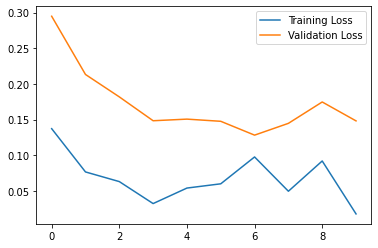

In [22]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.legend()

In [23]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

In [24]:
train_acc

[89.56666666666666,
 95.38833333333334,
 96.71833333333333,
 97.49,
 97.98833333333333,
 98.42166666666667,
 98.72,
 98.91333333333333,
 99.13,
 99.28666666666666]

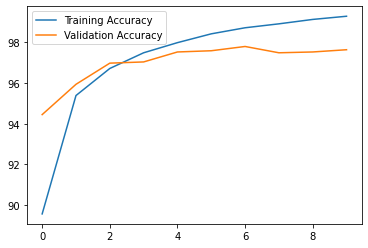

In [25]:
plt.plot(train_acc, label = "Training Accuracy")
plt.plot(test_acc, label = "Validation Accuracy")
plt.legend()

In [26]:
# New unseen data

test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [27]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val.data,1)[1]
        correct += (predicted == y_test).sum()

In [28]:
100*correct.item()/len(test_data)

97.64

In [29]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 972,    0,    5,    0,    2,    2,    5,    2,    6,    2],
       [   0, 1123,    3,    0,    0,    0,    2,    8,    0,    2],
       [   0,    3, 1002,    2,    1,    0,    1,    9,    4,    0],
       [   2,    3,    6,  987,    0,   10,    1,    1,    2,    3],
       [   1,    0,    2,    0,  966,    3,    5,    3,    3,   14],
       [   0,    0,    0,    7,    0,  861,    2,    1,    3,    2],
       [   1,    2,    2,    0,    5,    7,  942,    0,    2,    0],
       [   0,    0,    3,    5,    0,    1,    0,  983,    2,    0],
       [   2,    4,    9,    4,    1,    6,    0,    3,  947,    5],
       [   2,    0,    0,    5,    7,    2,    0,   18,    5,  981]])